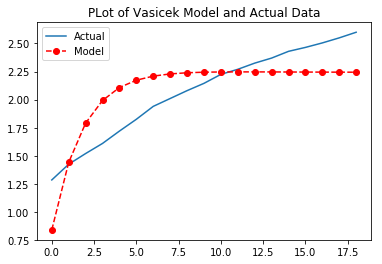

469.857865818


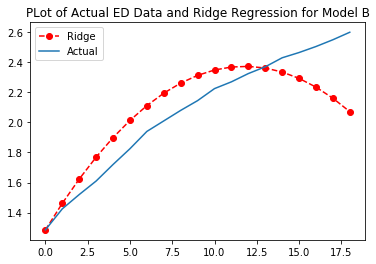

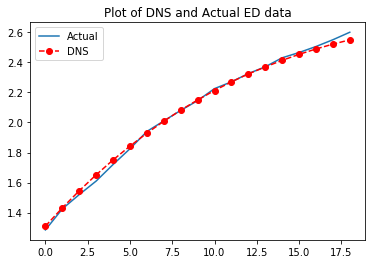

41703.1451848


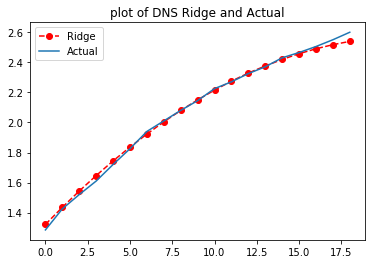

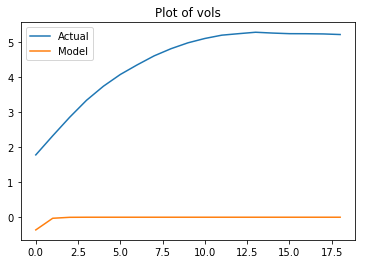

'References:\n    https://math.stackexchange.com/questions/583938/do-non-square-matrices-have-eigenvalues\n    https://www.math.nyu.edu/~benartzi/Slides10.2.pdf\n    https://pypi.python.org/pypi/Numdifftools\n    https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/'

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
import numdifftools as nd
from sklearn.linear_model import Ridge

file = 'data_finals.csv'
data = pd.read_csv(file, index_col=0)
futures = np.array(data['EDF_rates'])
R0= futures[0]/100 #base rate
vols = np.array(data['Vol'])
tenor = np.array(data['Tenor'])
constant_maturity = np.array(data['Constant_Maturity'])

sigma = 2.1
def forward(T, mu, kappa):
    term1 = mu/kappa
    term2 = np.exp(-kappa * T) * (R0 - mu/kappa)
    term3 = - sigma**2/2*kappa**2 * (1- np.exp(-kappa*T))**2
    return (term1 + term2 + term3)
    
p_optimal, p_covariance = curve_fit(forward, tenor, futures, bounds=(1.05,100))
forward_estimated=[forward(i,p_optimal[0],p_optimal[1]) for i in tenor]
plt.title("PLot of Vasicek Model and Actual Data")
plt.plot(futures, label='Actual');plt.plot(forward_estimated,label='Model',linestyle='--', marker='o', color='r')
plt.legend(loc='upper left');plt.show()

function = lambda z: (z[0]/z[1] + np.exp(-z[1] * tenor) * (R0- z[0]/z[1]) 
- (sigma**2)/(2*(z[1]**2)) *(1- np.exp(-z[1]*tenor))**2 - futures)**2

def Jacobian(func, poptimal):
    
    J = nd.Jacobian(func)
    Jacob_matrix= J(poptimal)
    jacobprod= np.matmul(np.transpose(Jacob_matrix),Jacob_matrix)
    return jacobprod

jacobprod1 = Jacobian(function,p_optimal)

def Function1(matrix):
    
    eig_values, eig_vector = np.linalg.eigh(matrix)
    eig_values=eig_values[::-1]
    collinearity= eig_values[0]/eig_values[len(eig_values)-1]
    return collinearity

print(Function1(jacobprod1))
#collinearity>10

#######Ridge Regression########
def RidgeRegression(data_regress):
    
    X_axis = pd.DataFrame(tenor)
    X_axis[1] = (X_axis.ix[:,0]**2)
    Y_axis = np.array(data_regress)
    ridge = Ridge(normalize=True)
    Y_axis = Y_axis.reshape([19,1])
    coefficients = []
    best_alpha=0
    min_mse = 10000000
    alphas = 10**np.linspace(0,-5,500)*1
    for a in alphas:
        ridge.set_params(alpha=a)
        ridge.fit(X_axis, Y_axis)
        coefficients.append(ridge.coef_)
        y_predicted=ridge.predict(X_axis)
        mse=mean_squared_error(Y_axis,y_predicted)
        if(mse<min_mse):
            min_mse=mse
            best_alpha=a
    #Ridge Regression Output
    ridge.set_params(alpha=best_alpha)
    ridge.fit(X_axis,Y_axis)
    fin_coef=ridge.coef_
    fin_coef=fin_coef[0][0]
    fitted_c=ridge.predict(X_axis)
    plt.plot(fitted_c,label='Ridge',linestyle='--', marker='o', color='r');plt.plot(futures,label='Actual')
    plt.legend(loc='upper left');plt.show()

plt.title('PLot of Actual ED Data and Ridge Regression for Model B')
RidgeRegression(forward_estimated)

########DNS#########
def DynamicNelsonSiegel(beta0,beta1,beta2,tau):
    return beta0 + beta1 * np.exp(-tau/optimal_lambda) + (tau/optimal_lambda)*beta2*np.exp(-tau/optimal_lambda)
#By trial and error (changing the values of lambda), I tried to reduce
#the RMSE. I got the optimal lambda as 8.3   
rmse_dns =[]  
for i in np.arange(7,9,0.1):
    optimal_lambda = i
    
    p_optimal2, p_covariance2 = curve_fit(DynamicNelsonSiegel,tenor,futures,bounds=(0.601,5))
    forward_estimated1=[DynamicNelsonSiegel(p_optimal2[0],p_optimal2[1],p_optimal2[2],i) for i in tenor]
    mse = mean_squared_error(forward_estimated1,futures)
    rmse_dns.append(mse)

optimal_lambda = 7 + 0.1 * np.where(rmse_dns==min(rmse_dns))[0]
p_optimal2, p_covariance2 = curve_fit(DynamicNelsonSiegel,tenor,futures,bounds=(0.601,5))
forward_estimated1=[DynamicNelsonSiegel(p_optimal2[0],p_optimal2[1],p_optimal2[2],i) for i in tenor]
plt.title('Plot of DNS and Actual ED data')
plt.plot(futures,label='Actual');plt.plot(forward_estimated1,label='DNS',linestyle='--', marker='o', color='r')
plt.legend(loc='upper left');plt.show()


function2 = lambda z: z[0] + z[1]*np.exp(-tenor/optimal_lambda) + (tenor/optimal_lambda)*z[2]*np.exp(-tenor/optimal_lambda)
jacobprod2 = Jacobian(function2, p_optimal2)
print(Function1(jacobprod2))

plt.title('plot of DNS Ridge and Actual')
RidgeRegression(forward_estimated1)

#I tried fitting the vol but was getting very off results. Below is my code
# which I believe is wrong. I wanted to attempt the second part so I didn't
#try further working on it


sigma_const= np.mean(vols)
def vol(kappa, T):
    return -sigma_const*(np.exp(-kappa*T))

p_optimal3, p_covariance3 = curve_fit(vol, constant_maturity, vols,bounds=(-1,10))
vol_estimated=[vol(p_optimal3[0],i) for i in constant_maturity]
plt.title('Plot of vols')
plt.plot(vols,label='Actual');plt.plot(vol_estimated,label='Model')
plt.legend(loc='upper left');plt.show()


"""References:
    https://math.stackexchange.com/questions/583938/do-non-square-matrices-have-eigenvalues
    https://www.math.nyu.edu/~benartzi/Slides10.2.pdf
    https://pypi.python.org/pypi/Numdifftools
    https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/"""
    
